[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lisuex/Machine-Learning2025/blob/main/Lab13.ipynb)

# Imports and Online dataset definition

In [ ]:
import torch, random, math, numpy as np
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# -------------------------------
# 0. Reproducibility and Setup
# -------------------------------
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# 1. Online dataset: 64×64, target = (cx,cy) ∈ [0,63]²  (float32)
# ============================================================
IMAGE = 64
SHAPES = ("circle", "square", "triangle")

def draw_shape(drawer, shape_type, center_x, center_y, radius):
    if shape_type == "circle":
        drawer.ellipse([center_x - radius, center_y - radius,
                        center_x + radius, center_y + radius], fill="black")
    elif shape_type == "square":
        drawer.rectangle([center_x - radius, center_y - radius,
                          center_x + radius, center_y + radius], fill="black")
    else:  # triangle
        drawer.polygon([
            (center_x, center_y - radius),
            (center_x - radius, center_y + radius),
            (center_x + radius, center_y + radius)
        ], fill="black")

class OddXYDataset(Dataset):
    """
    Generates images on-the-fly:
      * several random shapes of the same type
      * 1 additional shape of a different type
    Returns:
      * image (1×64×64 tensor, float32 normalized to [0,1])
      * label: float tensor [cx, cy] with center of the odd shape
    Arguments:
        num_samples             – total number of samples in the dataset
        same_shape_count_range – tuple (min, max), number of identical shapes
        shape_radius_range      – tuple (min_radius, max_radius) for shape size
    """
    def __init__(self,
                 num_samples,
                 same_shape_count_range=(3, 6),
                 shape_radius_range=(4, 10)):
        self.num_samples = num_samples
        self.same_shape_count_range = same_shape_count_range
        self.radius_min, self.radius_max = shape_radius_range

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        base_shape = random.choice(SHAPES)
        odd_shape = random.choice([s for s in SHAPES if s != base_shape])

        img = Image.new("L", (IMAGE, IMAGE), "white")
        drawer = ImageDraw.Draw(img)

        # draw identical shapes
        for _ in range(random.randint(*self.same_shape_count_range)):
            radius = random.randint(self.radius_min, self.radius_max)
            cx = random.randint(radius, IMAGE - radius - 1)
            cy = random.randint(radius, IMAGE - radius - 1)
            draw_shape(drawer, base_shape, cx, cy, radius)

        # draw the odd shape (with known center)
        radius = random.randint(self.radius_min, self.radius_max)
        cx = random.randint(radius, IMAGE - radius - 1)
        cy = random.randint(radius, IMAGE - radius - 1)
        draw_shape(drawer, odd_shape, cx, cy, radius)

        img_tensor = torch.tensor(np.array(img), dtype=torch.float32).unsqueeze(0) / 255.
        label_tensor = torch.tensor([float(cx), float(cy)], dtype=torch.float32)
        return img_tensor, label_tensor

def show_examples(num_examples=10):
    """
    Displays a grid of image samples from OddXYDataset using a DataLoader with batch_size=1.

    Args:
        num_examples (int): Number of examples to display.
    """
    dataset = OddXYDataset(num_samples=num_examples)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    num_columns = 5
    num_rows = math.ceil(num_examples / num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))

    for i, (image, label) in enumerate(dataloader):
        if i >= num_examples:
            break
        image_np = image.squeeze(0).squeeze(0).numpy()  # B=1,C=1,H,W --> H,W
        cx, cy = label.squeeze(0)                       # B=1,2       --> 2
        axes.flat[i].imshow(image_np, cmap="gray")
        axes.flat[i].set_title(f"({cx:.0f},{cy:.0f})")
        axes.flat[i].axis("off")

    for j in range(i + 1, num_rows * num_columns):
        axes.flat[j].axis("off")

    plt.tight_layout()
    plt.show()

# Model definitions

In [ ]:
# -------------------------------
# 2. Positional Encoding Module
# -------------------------------
class PosEnc(nn.Module):
    def __init__(self, d_model, L):
        super().__init__()
        pe = torch.zeros(L, d_model)             # (L,d_model)
        pos = torch.arange(L).unsqueeze(1).float()# (L,1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000)/d_model))
        pe[:,0::2], pe[:,1::2] = torch.sin(pos*div), torch.cos(pos*div)
        self.register_buffer('pe', pe)
    def forward(self, x):
        # x: (B, L, d_model)
        return x + self.pe.unsqueeze(0)  # returns (B, L, d_model)

# -------------------------------
# 3. Encoder: Conv -> Tokens -> PosEnc
# -------------------------------
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # conv: input (B,1,64,64) -> (B,32,64,64) -> (B,16,12,12)
        self.conv = nn.Sequential(
            nn.Conv2d(1,32, kernel_size=3, padding=1),  # -> (B,32,64,64)
            nn.ReLU(),
            nn.Conv2d(32,16, kernel_size=20, stride=4),  # -> (B,16,12,12)
            nn.ReLU()
        )
        self.L, self.d = 12*12, 16
        self.pos_enc = PosEnc(self.d, self.L)
    def forward(self, x):
        f = self.conv(x)                                 # f: (B,16,12,12)
        tokens = f.flatten(2).transpose(1,2)             # tokens: (B,144,16)
        out = self.pos_enc(tokens)                      # out: (B,144,16)
        return out

# -------------------------------
# 4. Full Locator: Coarse+Offset
# -------------------------------
class LocatorFull(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.enc = encoder
        d, L = encoder.d, encoder.L
        self.attn   = nn.MultiheadAttention(d, num_heads=4, batch_first=True)
        self.ln1    = nn.LayerNorm(d)
        self.ff     = nn.Sequential(nn.Linear(d,64), nn.ReLU(), nn.Dropout(0.1), nn.Linear(64,d))
        self.ln2    = nn.LayerNorm(d)
        self.cls    = nn.Sequential(nn.Linear(d,32), nn.ReLU(), nn.Dropout(0.1), nn.Linear(32,1))
        self.offset = nn.Sequential(nn.Linear(d,32), nn.ReLU(), nn.Dropout(0.1), nn.Linear(32,2))
        # Precomputed grid centers for each token
        coords = [[(i%12)*4 + 10, (i//12)*4 + 10] for i in range(L)]
        self.register_buffer('centers', torch.tensor(coords, dtype=torch.float32))  # (144,2)
    def forward(self, x):
        B = x.size(0)
        z, attn_weights = None, None
        z = self.enc(x)                                # z: (B,144,16)
        attn_out, attn_weights = self.attn(z, z, z, need_weights=True)  # attn_out: (B,144,16), attn_weights: (B,144,144)
        y = self.ln1(z + attn_out)                     # y: (B,144,16)
        ff = self.ff(y)                                # ff: (B,144,16)
        z2 = self.ln2(y + ff)                          # z2: (B,144,16)
        logits = self.cls(z2).squeeze(-1)              # logits: (B,144)
        P = F.softmax(logits, dim=-1)                  # P: (B,144)
        centers = self.centers.unsqueeze(0).expand(B,-1,-1)  # (B,144,2)
        coarse = torch.bmm(P.unsqueeze(1), centers).squeeze(1)  # coarse: (B,2)
        offs   = self.offset(z2)                       # offs: (B,144,2)
        fine   = torch.bmm(P.unsqueeze(1), offs).squeeze(1)     # fine: (B,2)
        return coarse + fine, attn_weights            # coords: (B,2), attn_weights: (B,144,144)


# Training

In [ ]:
# -------------------------------
# 5. Training Loop & Loss Plot
# -------------------------------
enc    = Encoder().to(device)
model  = LocatorFull(enc).to(device)
opt    = torch.optim.Adam(model.parameters(), lr=1e-3)
crit   = nn.MSELoss()
loader = DataLoader(OddXYDataset(25000), batch_size=64, shuffle=True, num_workers=2)

epochs = 30
rmse_list = []
print("Training Full Locator...")
for ep in range(1, epochs+1):
    total_loss = 0.0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds, _ = model(imgs)                        # preds: (B,2)
        loss = crit(preds, lbls)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()
    rmse = math.sqrt(total_loss / len(loader))
    rmse_list.append(rmse)
    print(f" Epoch {ep:02d}/{epochs}: RMSE={rmse:.3f}")

Training Full Locator...
 Epoch 01/30: RMSE=13.313
 Epoch 02/30: RMSE=11.246
 Epoch 03/30: RMSE=8.880
 Epoch 04/30: RMSE=8.449
 Epoch 05/30: RMSE=7.259
 Epoch 06/30: RMSE=5.079
 Epoch 07/30: RMSE=4.209
 Epoch 08/30: RMSE=4.005
 Epoch 09/30: RMSE=3.723
 Epoch 10/30: RMSE=3.659
 Epoch 11/30: RMSE=3.544
 Epoch 12/30: RMSE=3.420
 Epoch 13/30: RMSE=3.232
 Epoch 14/30: RMSE=3.386
 Epoch 15/30: RMSE=3.227
 Epoch 16/30: RMSE=3.308
 Epoch 17/30: RMSE=3.112
 Epoch 18/30: RMSE=3.184
 Epoch 19/30: RMSE=3.269
 Epoch 20/30: RMSE=3.104
 Epoch 21/30: RMSE=2.993
 Epoch 22/30: RMSE=3.023
 Epoch 23/30: RMSE=2.954
 Epoch 24/30: RMSE=3.043
 Epoch 25/30: RMSE=3.027
 Epoch 26/30: RMSE=2.947
 Epoch 27/30: RMSE=2.939
 Epoch 28/30: RMSE=2.890
 Epoch 29/30: RMSE=2.901
 Epoch 30/30: RMSE=2.965


# Plot RMSE curve

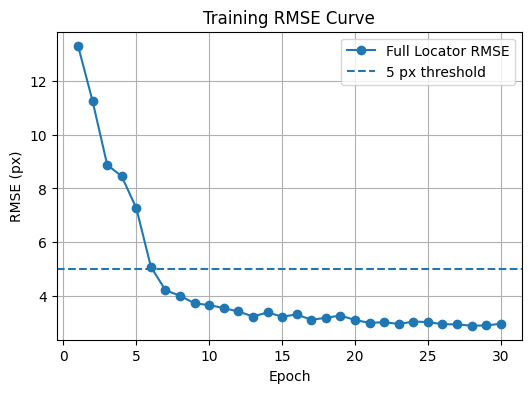

In [ ]:
# Plot RMSE curve with threshold
plt.figure(figsize=(6,4))
plt.plot(range(1, len(rmse_list)+1), rmse_list, marker='o', label='Full Locator RMSE')
plt.axhline(5.0, linestyle='--', label='5 px threshold')
plt.xlabel('Epoch'); plt.ylabel('RMSE (px)')
plt.title('Training RMSE Curve'); plt.legend(); plt.grid(True)
plt.show()

# Plot Attention Visualization

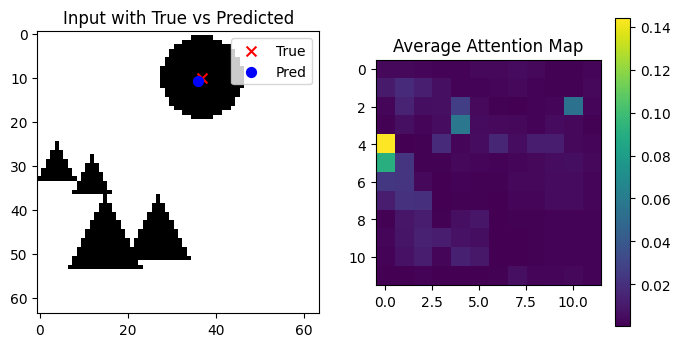

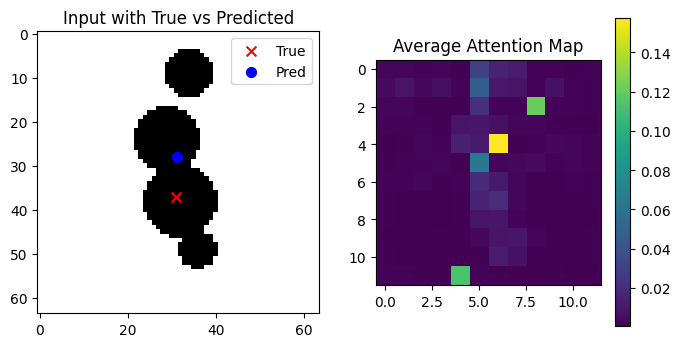

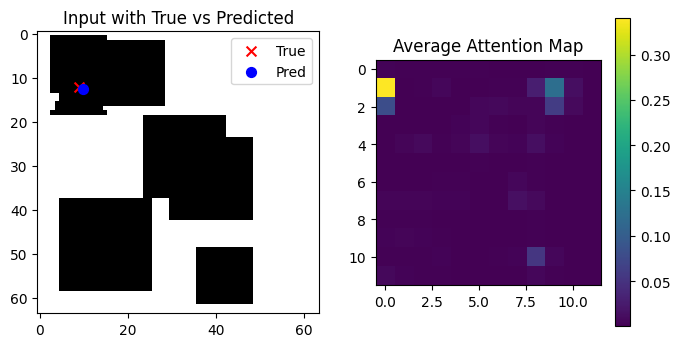

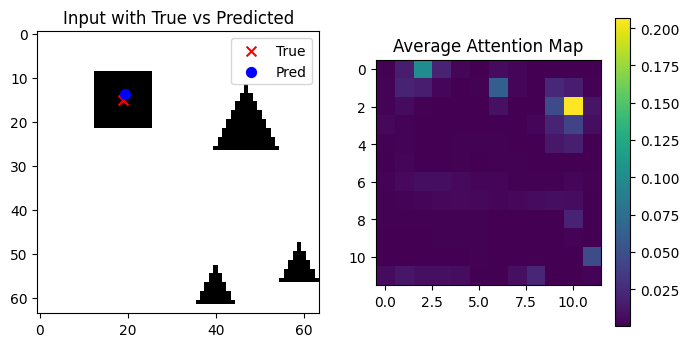

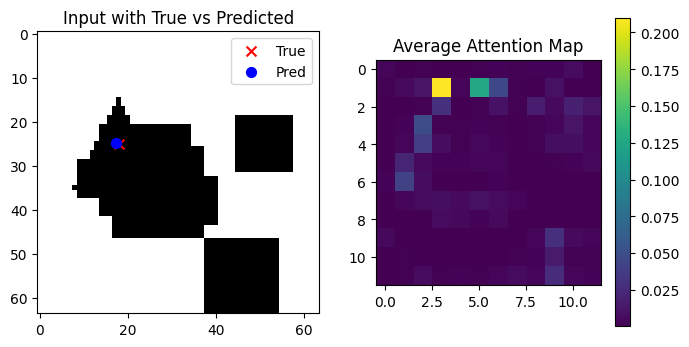

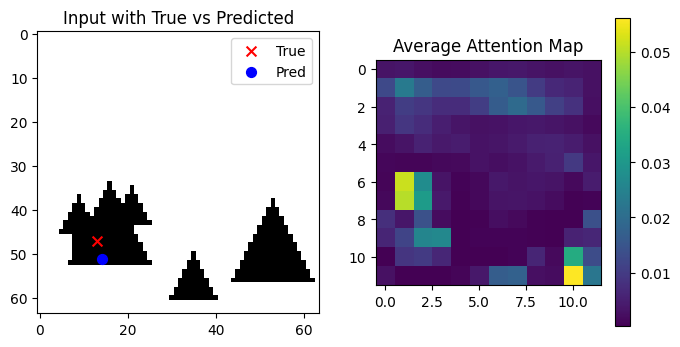

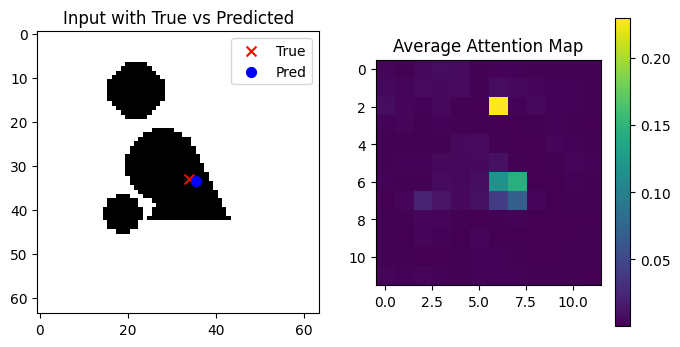

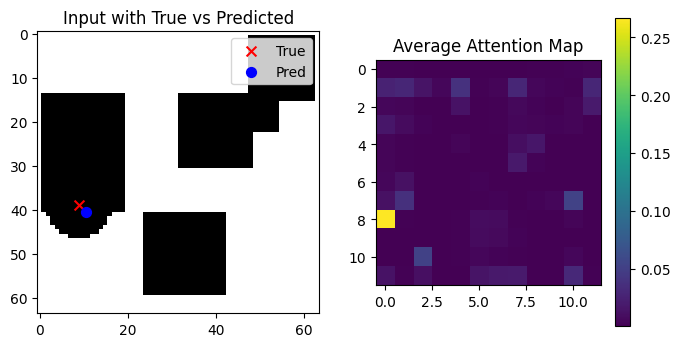

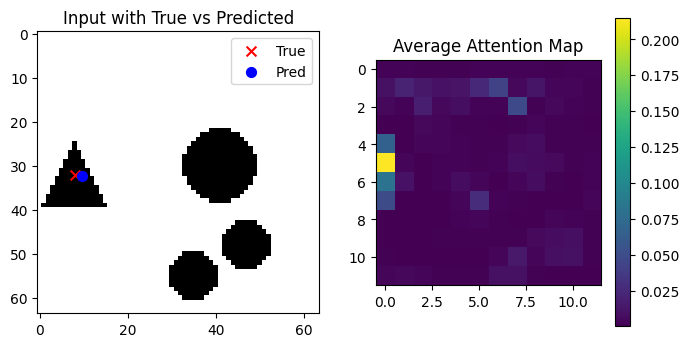

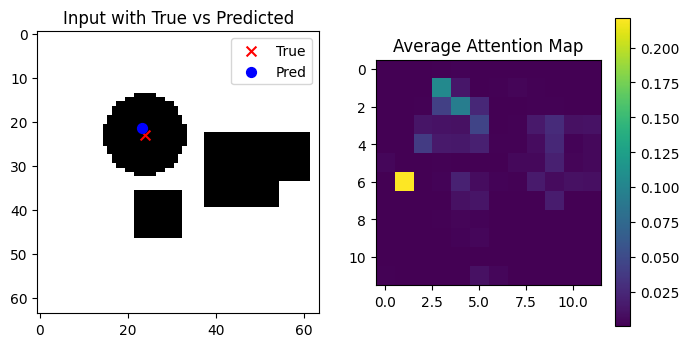

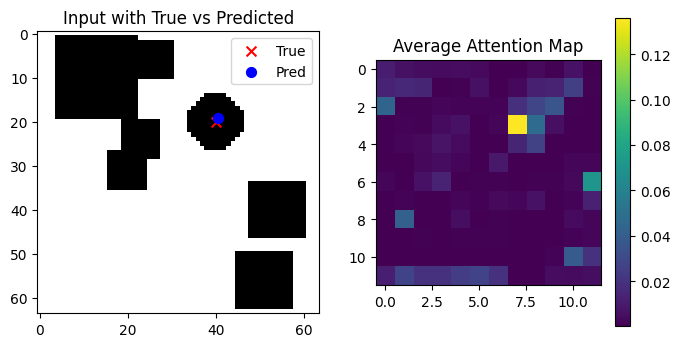

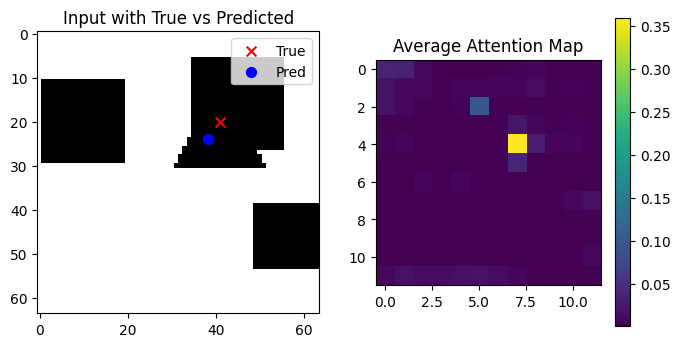

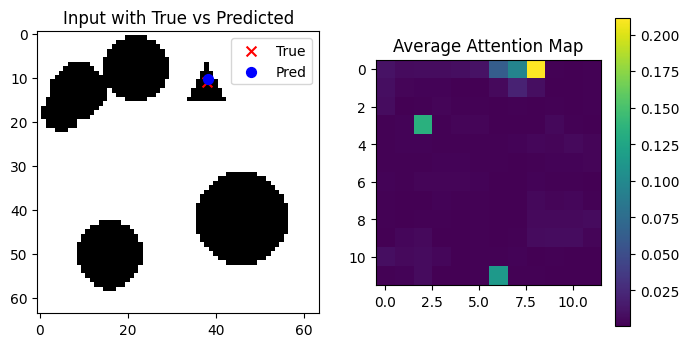

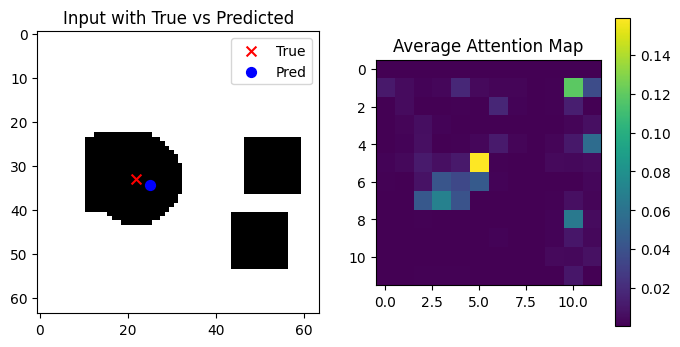

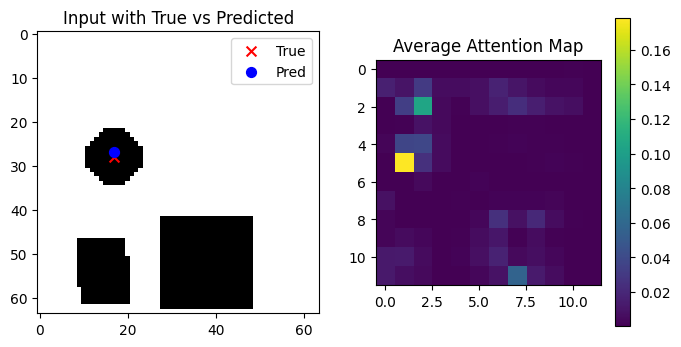

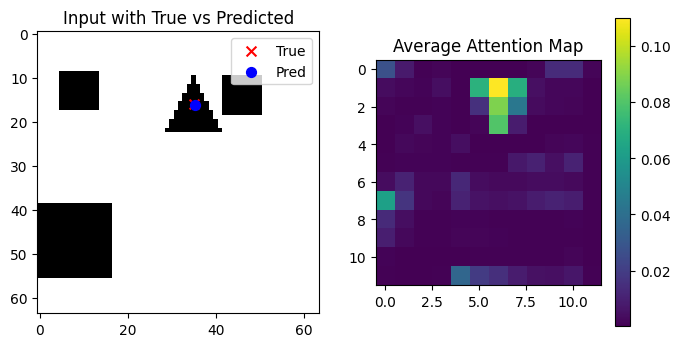

In [ ]:
# -------------------------------
# 6. Attention Visualization
# -------------------------------
# Visualize attention maps for a batch of samples

number_of_examples = 16
imgs, lbls = next(iter(loader))
imgs = imgs[:number_of_examples].to(device)  # select first 4
coords, attn_w = model(imgs)  # coords: (4,2), attn_w: (4,144,144)
for i in range(number_of_examples):
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    # show image
    ax[0].imshow(imgs[i].cpu().squeeze(), cmap='gray')
    ax[0].scatter([lbls[i][0]], [lbls[i][1]], s=50, c='r', marker='x', label='True')
    ax[0].scatter([coords[i][0].item()], [coords[i][1].item()], s=50, c='b', marker='o', label='Pred')
    ax[0].legend(); ax[0].set_title('Input with True vs Predicted')
    # attention map: average over query tokens
    avg_attn = attn_w[i].mean(dim=0).reshape(12,12).cpu().detach().numpy()
    im = ax[1].imshow(avg_attn, cmap='viridis')
    ax[1].set_title('Average Attention Map')
    fig.colorbar(im, ax=ax[1])
    plt.show()

# Discussion

In general, the model pays attention to the proper odd shape, in most cases points with the highest attention are located next to the odd shapes.

While usually the point with the highest value (yellow point) lies nearby odd shape center, sometimes this point is lonely in a sense all of the points around has low attention values, and the bigger "high attention area" is located somewhere else.

So while the final predictions of the model are accurate, sometimes it puts more focus on bigger areas with high attention values in the wrong place.
Sometimes this wrong places are around corners, edges, or around another "strange shapes" (for example other's shapes intersection).

Additionally, sometimes the places with high attention values are located in the "center of chaos" which not always lays on some element, sometimes in the empty place, which means model sometimes put too much focus/influence on the pixels located too far from the considered element